In [1]:
include("../speciale_tools.jl")
import JLD
import PyPlot

In [2]:
figure_folder = "/home/data/simon/result/figures_repport/results"

"/home/data/simon/result/figures_repport/results"

## Huston 



In [3]:
data_folder = "/home/data/simon/processed/test_areas/houston_new"
#data_folder = "/Users/simon/Documents/DTU fag/Speciale/ribe_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);
coh = [abs.(band) for band in _load_jld(coherence_VV_files[1:5],data_folder)]
coh = [coh[1][:,end:-1:1],(sum(coh[2:end])./length(coh[2:end]))[:,end:-1:1]];

VV = _load_jld(VV_files[1:6],data_folder)
VV_pre = dropdims(Statistics.median(cat(VV[2:end]...,dims=3),dims=3),dims=3)[:,end:-1:1];
VV_co = copy(VV[1])[:,end:-1:1]
VV = 0;


VH = _load_jld(VH_files[1:6],data_folder)
VH_pre = dropdims(Statistics.median(cat(VH[2:end]...,dims=3),dims=3),dims=3)[:,end:-1:1];
VH_co = copy(VH[1])[:,end:-1:1]
VH = 0;

In [4]:
hsba_VV = JLD.load(joinpath(data_folder,"hsba_VV.jld"),"data");
hsba_vh = JLD.load(joinpath(data_folder,"hsba_VH.jld"),"data");
hsba_building = JLD.load(joinpath(data_folder,"hsba_building.jld"),"data");
chini_bare_soil = JLD.load(joinpath(data_folder,"bare_soil_chini.jld"),"data")[:,end:-1:1].>0.5;
chini_urban = JLD.load(joinpath(data_folder,"urban_flood_chini.jld"),"data")[:,end:-1:1].>0.5;
chini_buildings = JLD.load(joinpath(data_folder,"chini_building.jld"),"data")[:,end:-1:1].>0.5;

In [5]:
own_bare_soil = JLD.load(joinpath(data_folder,"own_bare_soil.jld"),"data")
own_urban_flood = JLD.load(joinpath(data_folder,"own_urban_flood.jld"),"data");



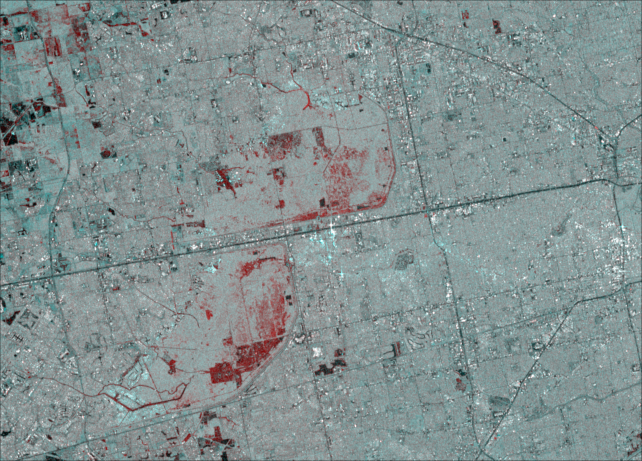

In [6]:
imgVV = pretty_img([VV_co,VV_pre],min_vv,max_vv)
imgVH = pretty_img([VH_co,VH_pre],min_vh,max_vh)

In [7]:
img_bw = pretty_img([VV_co,VV_co],min_vv,max_vv,1);
img_bw_vh = pretty_img([VH_co,VH_co],min_vh,max_vh,1);

## Bare_soil

### VH

In [31]:
flood_band = 10 .*log10.(VH_co);
ref_band = 10 .*log10.(VH_pre);
change_band = flood_band .- ref_band;

In [32]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;

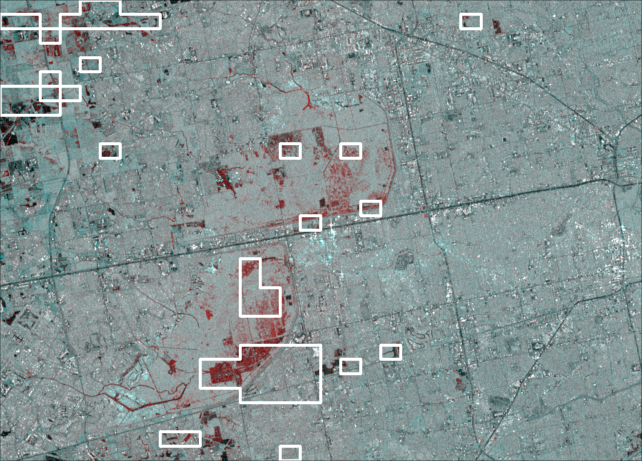

In [33]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVH,get_edges(bm_mask),(1,1,1)) # white

file_path = joinpath(figure_folder,"houston_vh_tiles")
FileIO.save(file_path*".png",img_save)
img_save

In [34]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;
y_seed

-21.325000000000003

In [40]:
t_0 = [-18.2, -0.2]
res = Optim.optimize(
    t -> sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0)
thresholds1 = res.minimizer
f1 = sse_water_fit2(flood_band,change_band,ref_band,y_seed,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()


([-18.762756347656243, -0.17540893554687492], 0.00014992050777437404)

In [41]:
rg_mask = (flood_band .<thresholds1[1]) .& (change_band.<thresholds1[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [42]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<thresholds1[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);

In [43]:
hsba_vh = flood_mask .& .!(ref_mask);

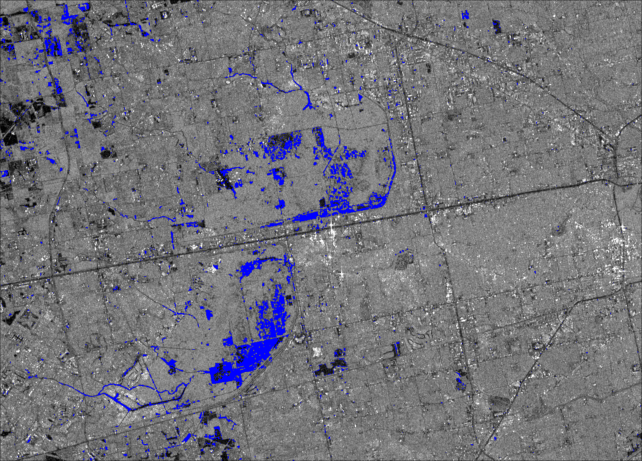

In [45]:
img_save = add_mask(img_bw_vh,hsba_vh,(0,0,1)) # 

file_path = joinpath(figure_folder,"houston_vh_flood")
FileIO.save(file_path*".png",img_save)
img_save

In [46]:
file_name = joinpath(data_folder,"hsba_VH.jld")
JLD.save(file_name, "data",hsba_vh);

### Chini bare_soil

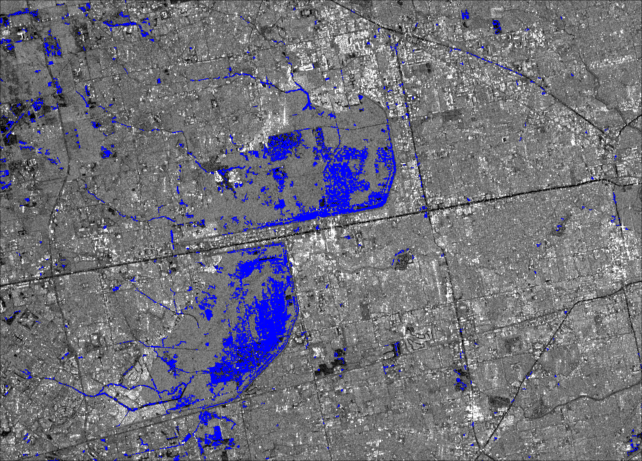

In [47]:
img_save = add_mask(img_bw,chini_bare_soil,(0,0,1))


file_path = joinpath(figure_folder,"houston_chini_bare")
FileIO.save(file_path*".png",img_save)
img_save

### compare

In [49]:
length(chini_bare_soil)

1181643

In [90]:
flood_maps = [hsba_VV,hsba_vh,own_bare_soil,chini_bare_soil ];

In [91]:
i =1
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (1.0, 29059)                
 (0.282816529341468, 8993)   
 (0.42105263157894735, 17992)
 (0.40654943882471223, 19814)

In [92]:
i =2
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (0.309473829106301, 8993)   
 (1.0, 31798)                
 (0.5555919589993213, 23741) 
 (0.41385395079713566, 20170)

In [93]:
i =3
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (0.6191541346914897, 17992)
 (0.7466192842317126, 23741)
 (1.0, 42731)               
 (0.6478855900034881, 31576)

In [94]:
i =4
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (0.6818541587804122, 19814)
 (0.6343166236870244, 20170)
 (0.7389483045096066, 31576)
 (1.0, 48737)               

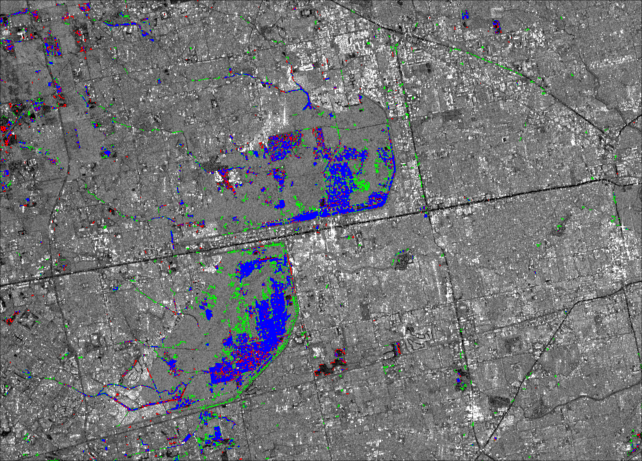

In [69]:
img_save = add_mask(img_bw,chini_bare_soil,(0,1,0)) ### Green
img_save = add_mask(img_save,own_bare_soil,(1,0,0)) ### red

img_save = add_mask(img_save,chini_bare_soil .&own_bare_soil ,(0,0,1))

file_path = joinpath(figure_folder,"houston_chini_vs_own")
FileIO.save(file_path*".png",img_save)
img_save

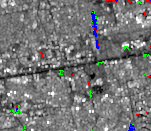

In [90]:
img_save[450:580,250:400]

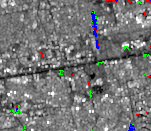

In [91]:
file_path = joinpath(figure_folder,"houston_chini_vs_own_zoom4")
FileIO.save(file_path*".png",img_save[450:580,250:400])
img_save[450:580,250:400]

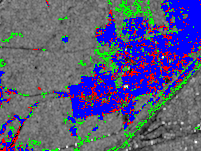

In [77]:
file_path = joinpath(figure_folder,"houston_chini_vs_own_zoom1")
FileIO.save(file_path*".png",img_save[650:800,350:550])
img_save[650:800,350:550]

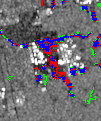

In [81]:
file_path = joinpath(figure_folder,"houston_chini_vs_own_zoom2")
FileIO.save(file_path*".png",img_save[300:420,400:500])
img_save[300:420,400:500]


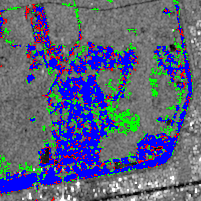

In [84]:
file_path = joinpath(figure_folder,"houston_chini_vs_own_zoom3")
FileIO.save(file_path*".png",img_save[250:450,600:800])
img_save[250:450,600:800]


### Urban

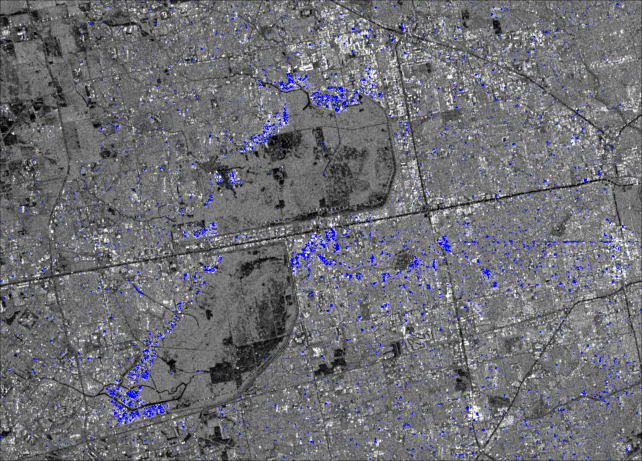

In [54]:
img_save = add_mask(img_bw,chini_urban,(0,0,1)) ### Green
file_path = joinpath(figure_folder,"houston_chini_urban")
FileIO.save(file_path*".png",img_save)
img_save


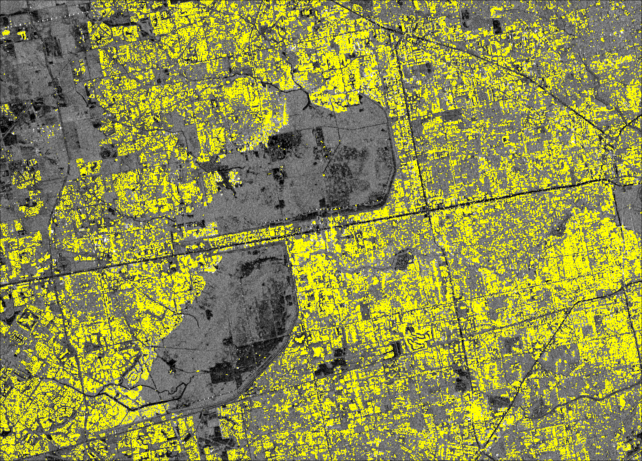

In [55]:
img_save = add_mask(img_bw,chini_buildings,(1,1,0)) ### Green

file_path = joinpath(figure_folder,"houston_chini_buildings")
FileIO.save(file_path*".png",img_save)
img_save


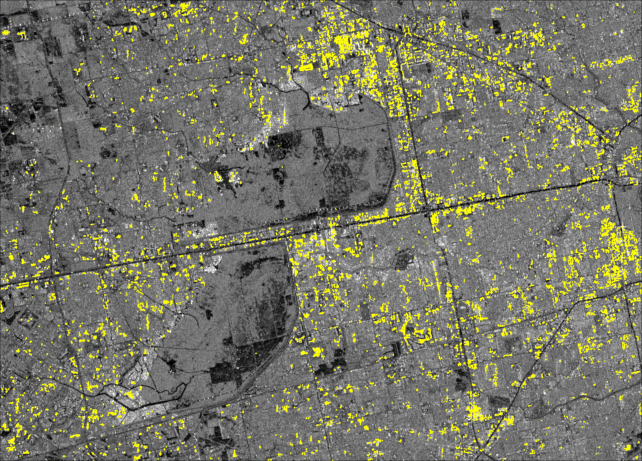

In [8]:
img_save = add_mask(img_bw,hsba_building,(1,1,0)) ### Green

file_path = joinpath(figure_folder,"houston_hsba_buildings")
FileIO.save(file_path*".png",img_save)
img_save

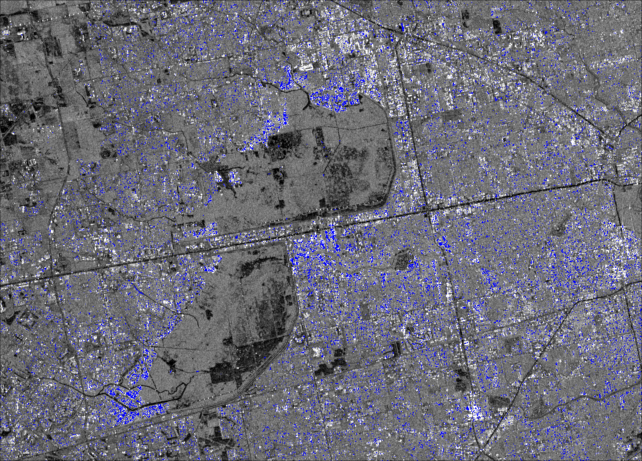

In [56]:
urban_cb_oc = chini_buildings .& ((coh[1].-coh[2]).<-0.25)
img_save = add_mask(img_bw,urban_cb_oc,(0,0,1)) ### Green

file_path = joinpath(figure_folder,"houston_chini_bulding_own_coh")
FileIO.save(file_path*".png",img_save)
img_save


In [49]:
length(chini_bare_soil)

1181643

In [85]:
flood_maps = [own_urban_flood,chini_urban];

In [86]:
i =1
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

2-element Array{Tuple{Float64,Int64},1}:
 (1.0, 8769)                
 (0.17114315699459712, 4403)

In [87]:
i =2
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

2-element Array{Tuple{Float64,Int64},1}:
 (0.5021097046413502, 4403)
 (1.0, 25727)              

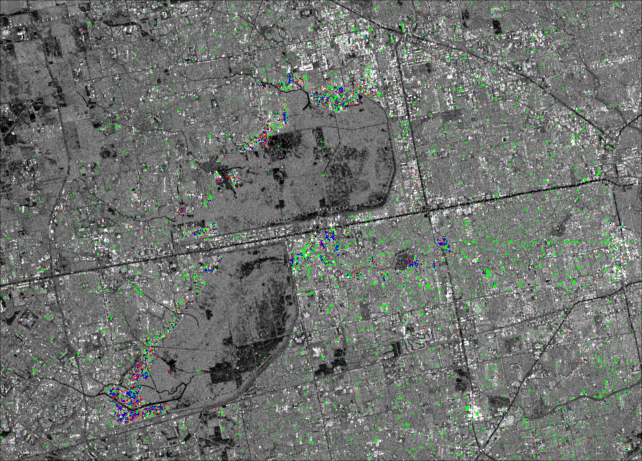

In [8]:
img_save = add_mask(img_bw,chini_urban,(0,1,0)) ### Green
img_save = add_mask(img_save,own_urban_flood,(1,0,0)) ### red

img_save = add_mask(img_save,chini_urban .&own_urban_flood ,(0,0,1))

file_path = joinpath(figure_folder,"houston_chini_vs_own_urban")
FileIO.save(file_path*".png",img_save)
img_save

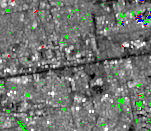

In [9]:
img_save[320:420,250:400]

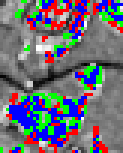

In [77]:
file_path = joinpath(figure_folder,"houston_chini_vs_own_urban_zoom1")
FileIO.save(file_path*".png",img_save[750:800,250:290])
img_save[750:800,250:290]

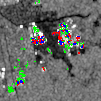

In [78]:
file_path = joinpath(figure_folder,"houston_chini_vs_own_urban_zoom2")
FileIO.save(file_path*".png",img_save[320:420,400:500])
img_save[320:420,400:500]

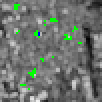

In [79]:
file_path = joinpath(figure_folder,"houston_chini_vs_own_urban_zoom3")
FileIO.save(file_path*".png",img_save[450:500,300:350])
img_save[450:500,300:350]

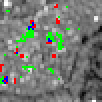

In [80]:
file_path = joinpath(figure_folder,"houston_chini_vs_own_urban_zoom3")
FileIO.save(file_path*".png",img_save[490:540,750:800])
img_save[490:540,750:800]

In [ ]:
img_save[490:540,750:800]

In [95]:
zip_folder(figure_folder)

Process(`zip -q -j -r /home/data/simon/result/figures_repport/results.zip /home/data/simon/result/figures_repport/results`, ProcessExited(0))